# Introduction To GradCAM (Part 1) - Lecture Notebook

In this lecture notebook we'll be looking at an introduction to Grad-CAM, a powerful technique for interpreting Convolutional Neural Networks. Grad-CAM stands for Gradient-weighted Class Activation Mapping.

CNN's are very flexible models and their great predictive power comes at the cost of losing interpretability (something that is true for all Artificial Neural Networks). Grad-CAM attempts to solve this by giving us a graphical visualisation of parts of an image that are the most relevant for the CNN when predicting a particular class.

Aside from working on some Grad-CAM concepts we'll also look at how we can use Keras to access some concrete information of our model. Let's dive into it!

In [1]:
import keras
from keras import backend as K
from util import *

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

The `load_C3M3_model()` function has been taken care of and its internals are out of the scope of this notebook. But if it intrigues you, you can take a look at it in `util.py` 

In [4]:
# Load the model we are going to be using
model = load_C3M3_model()

Got loss weights
Loaded DenseNet
Added layers
Compiled Model
Loaded Weights


As you may already know, we can check the architecture of our model using the `summary()` method. 

After running the code block below we’ll see that this model has a lot of layers. One advantage of Grad-CAM over previous attempts of interpreting CNN's (such as CAM) is that it is architecture agnostic. This means it can be used for CNN's with complex architectures such as this one:

In [5]:
# Print all of the model's layers
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

Keras models include abundant information about the elements that make them up. You can check all of the available methods and attributes of this class by using the `dir()` method:

In [6]:
# Printing out methods and attributes for Keras model
print(f"Keras' models have the following methods and attributes: \n\n{dir(model)}")

Keras' models have the following methods and attributes: 

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_inbound_node', '_add_unique_metric_name', '_base_init', '_built', '_cache_output_metric_attributes', '_check_trainable_weights_consistency', '_collected_trainable_weights', '_compile_metric_functions', '_compile_metrics', '_compile_weighted_metrics', '_compute_previous_mask', '_expects_training_arg', '_feed_input_names', '_feed_input_shapes', '_feed_inputs', '_feed_loss_fns', '_feed_output_names', '_feed_output_shapes', '_feed_outputs', '_feed_sample_weight_modes', '_feed_sample_weights', '_feed_targets', '_function_kwargs', '_get_callback_

Wow, this certainly is a lot! These models are indeed very complex. 

What we are interested in are the layers of the model which can be easily accessed as an attribute using the dot notation. They are a list of layers, which can be confirmed by checking its type:

In [13]:
# Check the type of the model's layers
print(type(model.layers))
model._layers==model.layers

<class 'list'>


True

In [22]:
# Print 5 first layers along with their names
for i in range(5):
    l = model.layers[i]
    print(f"Layer number {i}: \n{l} \nWith name: {l.name} \n")

Layer number 0: 
With name: input_2 

Layer number 1: 
With name: zero_padding2d_3 

Layer number 2: 
With name: conv1/conv 

Layer number 3: 
With name: conv1/bn 

Layer number 4: 
With name: conv1/relu 



Let's check how many layers our model has:

In [23]:
# Print number of layers in our model
print(f"The model has {len(model.layers)} layers")

The model has 429 layers


Our main goal is interpreting the representations which the neural net is creating for classifying our images. But as you can see this architecture has many layers. 

Actually we are really interested in the representations that the convolutional layers produce because these are the layers that (hopefully) recognize concrete elements within the images. We are also interested in the "concatenate" layers because in our model's arquitecture they concatenate convolutional layers.

Let's check how many of those we have:

In [24]:
# Number of layers that are of type "Convolutional" or "Concatenate"
len([l for l in model.layers if ("conv" in str(type(l))) or ("Concatenate" in str(type(l)))])

180

This number is still very big to try to interpret each one of these layers individually. 

One characteristic of CNN's is that the earlier layers capture low-level features such as edges in an image while the deeper layers capture high-level concepts such as physical features of a "Cat". 

Because of this **Grad-CAM usually focuses on the last layers, as they provide a better picture of what the network is paying attention to when classifying a particular class**. Let's grab the last concatenate layer of our model. Luckily Keras API makes this quite easy:

In [25]:
# Save the desired layer in a variable
layer = model.layers[424]

# Print layer
layer

This approach is not the best since we will need to know the exact index of the desired layer. Luckily we can use the `get_layer()` method in conjunction with the layer's name to get the same result. 

Remember you can get the name from the information displayed earlier with the `summary()` method.

In [26]:
# Save the desired layer in a variable
layer = model.get_layer("conv5_block16_concat")

# Print layer
layer

Let's check what methods and attributes we have available when working with this layer:

In [27]:
# Printing out methods and attributes for Keras' layer
print(f"Keras' layers have the following methods and attributes: \n\n{dir(layer)}")

Keras' layers have the following methods and attributes: 

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_inbound_node', '_built', '_compute_elemwise_op_output_shape', '_get_existing_metric', '_get_node_attribute_at_index', '_inbound_nodes', '_initial_weights', '_losses', '_merge_function', '_metrics', '_node_key', '_non_trainable_weights', '_outbound_nodes', '_per_input_losses', '_per_input_updates', '_reshape_required', '_trainable_weights', '_updates', 'add_loss', 'add_metric', 'add_update', 'add_weight', 'assert_input_compatibility', 'axis', 'build', 'built', 'call', 'compute_mask', 'compute_output_shape', 'count_params', 'dtype', 'from_config', 'get_config', 'get_input_a

Since we want to know the representations which this layer is abstracting from the images we should be interested in the output from this layer. Luckily we have this attribute available:

In [28]:
# Print layer's output
layer.output

<tf.Tensor 'conv5_block16_concat_1/concat:0' shape=(?, ?, ?, 1024) dtype=float32>

Do you notice something odd? The shape of this tensor is undefined for some dimensions. This is because this tensor is just a placeholder and it doesn't really contain information about the activations that occurred in this layer. 

To compute the actual activation values given an input we will need to use a **Keras function**.

This function accepts lists of input and output placeholders and can be used with an actual input to compute the respective output of the layer associated to the placeholder for that given input. 

Before jumping onto the Keras function we should rewind a little bit to get the placeholder tensor associated with the input. You can get this from the model’s input:

In [29]:
# Print model's input tensor placeholder
model.input

<tf.Tensor 'input_2:0' shape=(?, ?, ?, 3) dtype=float32>

We can see that this is a placeholder as well. Now let's instantiate our Keras function using Keras backend. Please be aware that this **function expects its arguments as lists or tuples**:

In [30]:
# Instantiate the function to compute the activations of the last convolutional layer == layer.output
last_layer_activations_function = K.function([model.input], [layer.output])

# Print the Keras function
last_layer_activations_function

Let's test the functions for computing the last layer activation which we just defined on a particular image. Don't worry about the code to load the image, this has been taken care of for you. You should only care that an image ready to be processed will be saved in the x variable:

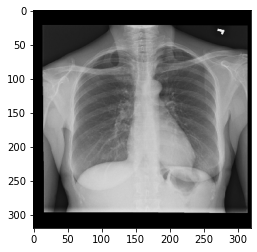

In [31]:
# Load dataframe that contains information about the dataset of images
df = pd.read_csv("nih_new/train-small.csv")

# Path to the actual image
im_path = 'nih_new/images-small/00000599_000.png'

# Load the image and save it to a variable
x = load_image(im_path, df, preprocess=False)

# Display the image
plt.imshow(x, cmap = 'gray')
plt.show()

We should normalize this image before going forward, this has also been taken care of:

In [32]:
# Calculate mean and standard deviation of a batch of images
mean, std = get_mean_std_per_batch(df)

# Normalize image
x = load_image_normalize(im_path, mean, std)

Now we have everything we need to compute the actual values of the last layer activations. In this case we should also **provide the input as a list or tuple**:

In [43]:
# Run the function on the image and save it in a variable
actual_activations = last_layer_activations_function([x])

An important intermediary step is to trim the batch dimension which can be done like this. This is necessary because we are applying Grad-CAM to a single image rather than to a batch of images:

In [53]:
# Remove batch dimension
#actual_activations = actual_activations[0][0, :]
print(last_layer_activations_function([x])[0][0] ) # the output it self is array of arrays as it expects batch 
# so we go into the batch array -first zero- and then take the first element -second zero-

[[[-2.78261840e-01  8.05400759e-02 -5.77156991e-02 ...  1.87665790e-01
   -7.16681704e-02  2.09874779e-01]
  [-3.78957361e-01 -5.51211655e-01 -8.98248851e-01 ...  2.67047107e-01
   -8.24482590e-02  3.11240286e-01]
  [-2.80272126e-01 -3.40894669e-01 -9.17753994e-01 ...  2.13774294e-01
   -6.74755871e-02  2.45911092e-01]
  ...
  [-3.68870556e-01 -3.43413591e-01 -8.91053319e-01 ...  1.17620841e-01
   -7.47135207e-02  1.49426073e-01]
  [-3.40745747e-01 -1.82536647e-01 -4.68728542e-01 ...  2.60678411e-01
   -1.07422769e-01  2.97527969e-01]
  [-2.93806344e-01  1.65219814e-01 -4.52439636e-02 ...  1.31258667e-01
   -6.57811463e-02  1.93917006e-01]]

 [[-4.18990523e-01  4.77962196e-02 -4.52567220e-01 ...  2.28334680e-01
   -1.11312225e-01  2.97349304e-01]
  [-2.06516638e-01 -4.85037953e-01 -2.51768768e-01 ...  4.03540194e-01
   -1.41748086e-01  4.66287255e-01]
  [-5.44632852e-01 -6.22890234e-01 -4.61141914e-01 ...  2.26541758e-01
   -1.03814304e-01  2.98429489e-01]
  ...
  [-4.07712340e-01 -8.4

In [35]:
# Remove batch dimension
actual_activations = actual_activations[0][0, :]
# Print shape of the activation array
print(f"Activations of last convolutional layer have shape: {actual_activations.shape}")

# Print activation array
actual_activations

Activations of last convolutional layer have shape: (10, 10, 1024)


array([[[-2.78261840e-01,  8.05400759e-02, -5.77156991e-02, ...,
          1.87665790e-01, -7.16681704e-02,  2.09874779e-01],
        [-3.78957361e-01, -5.51211655e-01, -8.98248851e-01, ...,
          2.67047107e-01, -8.24482590e-02,  3.11240286e-01],
        [-2.80272126e-01, -3.40894669e-01, -9.17753994e-01, ...,
          2.13774294e-01, -6.74755871e-02,  2.45911092e-01],
        ...,
        [-3.68870556e-01, -3.43413591e-01, -8.91053319e-01, ...,
          1.17620841e-01, -7.47135207e-02,  1.49426073e-01],
        [-3.40745747e-01, -1.82536647e-01, -4.68728542e-01, ...,
          2.60678411e-01, -1.07422769e-01,  2.97527969e-01],
        [-2.93806344e-01,  1.65219814e-01, -4.52439636e-02, ...,
          1.31258667e-01, -6.57811463e-02,  1.93917006e-01]],

       [[-4.18990523e-01,  4.77962196e-02, -4.52567220e-01, ...,
          2.28334680e-01, -1.11312225e-01,  2.97349304e-01],
        [-2.06516638e-01, -4.85037953e-01, -2.51768768e-01, ...,
          4.03540194e-01, -1.41748086e

Looks like everything worked out nicely! This is all for this lecture notebook (Grad-CAM Part 1). In Part 2 we will see how to calculate the gradients of the model's output with respect to the activations in this layer. This is the "Grad" part of Grad-CAM.

**Congratulations on finishing this lecture notebook!** Hopefully you will now have a better understanding of how to leverage Keras's API power for computing activations in specific layers. Keep it up!